In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

## Read in data and bootstrap

In [2]:
# File with effective mass output.
base = 'test_pion_mass_output/'
file = base + 'cl3_16_48_b6p1_m0p2450_output1.txt'

In [3]:
f = open(file, 'r')

In [4]:
# New read in format: Each line after the first of form cfgId|a1+ib a2+ib ...
f.readline()
L3 = 48    #temporal extent of lattice
C = []
for line in f:
    cur_line = np.zeros(L3, dtype=complex)
    cfgIdx, rest = line.split('|')
    cfgIdx = int(cfgIdx)
    interps = rest.split(' ')    # now get real and complex
    for n_t, x in enumerate(interps):
        if not x.isspace():
            real, imag = x.split('+i(')    #form should be x = a+i(b)
            real = float(real)
            imag = float(imag.replace(')', ''))
            cur_line[n_t] = complex(real, imag)
    #print(cur_line)
    cur_line = [cur_line]
    if C == []:
        C = np.array(cur_line)
    else:
        C = np.append(C, cur_line, axis = 0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [5]:
def bootstrap(C, n_boot = 500):
    num_configs = C.shape[0]
    n_t = C.shape[1]
    samples = np.zeros((n_boot, num_configs, n_t), dtype = complex)
    for i in range(n_boot):
        cfgIds = np.random.choice(num_configs, num_configs)    #Configuration ids to pick
        samples[i, :, :] = C[cfgIds, :]
    return samples

In [6]:
samples = bootstrap(C)
print(samples.shape)

(500, 253, 48)


## Compute correlation function and effective mass

In [7]:
# Compute ensemble average of each correlation function
ensemble_avg = np.mean(samples, axis = 1)
μ_C = np.abs(np.mean(ensemble_avg, axis = 0))
σ_C = np.abs(np.std(ensemble_avg, axis = 0))

In [8]:
# Compute effective mass
ratios = np.abs(ensemble_avg / np.roll(ensemble_avg, shift = -1, axis = 1))[:, :-1]
m_eff_ensemble = np.log(ratios)
μ_m_eff = np.mean(m_eff_ensemble, axis = 0)
σ_m_eff = np.std(m_eff_ensemble, axis = 0, ddof = 1)

In [10]:
# Compute cosh-corrected effective mass
N = 48
cosh_m_eff_ensemble = np.zeros(ratios.shape)
for ens_idx in range(ratios.shape[0]):
    for t in range(ratios.shape[1]):
        m = root(lambda m : ratios[ens_idx, t] - np.cosh(m * (t - N / 2)) / np.cosh(m * (t + 1 - N / 2)), \
                     m_eff_ensemble[ens_idx, t])
        cosh_m_eff_ensemble[ens_idx, t] = m.x
μ_cosh = np.mean(cosh_m_eff_ensemble, axis = 0)
σ_cosh = np.std(cosh_m_eff_ensemble, axis = 0, ddof = 1)

<IPython.core.display.Javascript object>


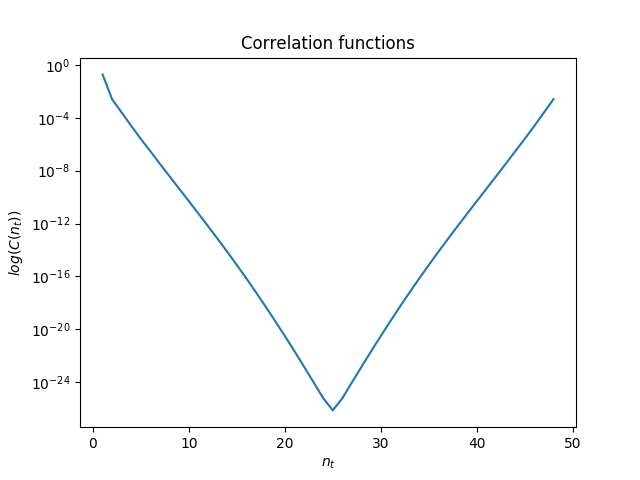

Text(0, 0.5, '$log(C(n_t))$')

In [12]:
plt.figure()
plt.errorbar(range(1, n_t + 1), μ_C, yerr = σ_C)
plt.yscale('log')
plt.title('Correlation functions')
plt.xlabel('$n_t$')
plt.ylabel('$log(C(n_t))$')

<IPython.core.display.Javascript object>


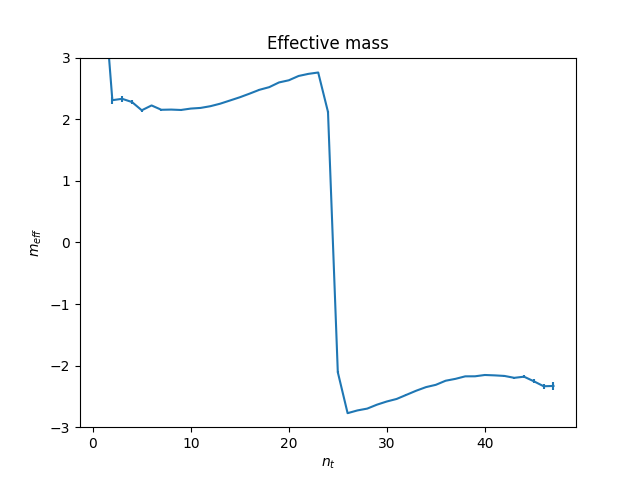

Text(0, 0.5, '$m_{eff}$')

In [13]:
plt.figure()
plt.errorbar(range(1, n_t), μ_m_eff, yerr = σ_m_eff)
plt.title('Effective mass')
plt.ylim((-3, 3))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')

<IPython.core.display.Javascript object>


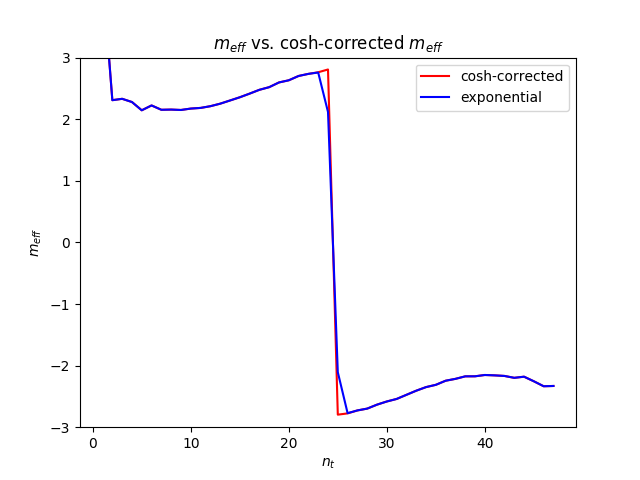

In [14]:
plt.figure()
# plt.plot(range(1, n_t), cosh_m_eff, 'r', label = 'cosh-corrected')
plt.plot(range(1, n_t), μ_cosh, 'r', label = 'cosh-corrected')
plt.plot(range(1, n_t), μ_m_eff, 'b', label = 'exponential')

plt.title('$m_{eff}$ vs. cosh-corrected $m_{eff}$')
plt.ylim((-3, 3))
plt.xlabel('$n_t$')
plt.ylabel('$m_{eff}$')
plt.legend()

plt.show()